In [24]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_model.load_state_dict(torch.load("h:\\Yehmh\\_model\\0514_fine_tune_sam_epoch100.pth"))


# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_model.to(device)

c:\Users\user\.conda\envs\RS\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [25]:
import tifffile
from patchify import patchify
import numpy as np

#Apply a trained model on large image
# large_test_image = tifffile.imread("i:\\2024_NDHU research assistant\\DNDF\\202309_大農大富RGB&NDVI\\pix4d file\\006\\006_transparent_mosaic_group1.tif")
# large_test_image = tifffile.imread("i:\\2024_NDHU research assistant\\DNDF\\86_1_clipped_image_2.tiff")
large_test_image = tifffile.imread("h:\\Yehmh\\FuShan\\202403\\202403_rgb.tif")

patches = patchify(large_test_image, (256, 256, 4), step=256)  #Step=256 for 256 patches means no overlap
patches = np.squeeze(patches)
patches = patches[:,:,:,:,:3]
# patches = patches[:,:,:,:3]

# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [26]:
import numpy as np

# Print the shapes of input_points and patches
print(np.array(input_points).shape)
print(patches.shape)

def is_not_mostly_white_or_black(image):
    unique, counts = np.unique(image, return_counts=True)
    pixel_counts = dict(zip(unique, counts))
    total_pixels = image.size // image.shape[-1]  # Dividing by 3 because it's an RGB image
    if pixel_counts.get(255, 0) < 0.9 * total_pixels and pixel_counts.get(0, 0) < 0.9 * total_pixels:
        return True
    return False

# Flatten patches to iterate through each image
flattened_patches = patches.reshape(-1, 256, 256, 3)

# Filter out mostly white or black patches
filtered_patches = [patch for patch in flattened_patches if is_not_mostly_white_or_black(patch)]

# Convert the list of valid patches back to a numpy array
filtered_patches = np.array(filtered_patches)

# Print progress
print(f"{filtered_patches.shape[0]} valid patches out of {flattened_patches.shape[0]}")

# Print the shape of the resulting patches array
print("patches shape:", filtered_patches.shape)


(1, 1, 100, 2)
(117, 112, 256, 256, 3)
10314 valid patches out of 13104
patches shape: (10314, 256, 256, 3)


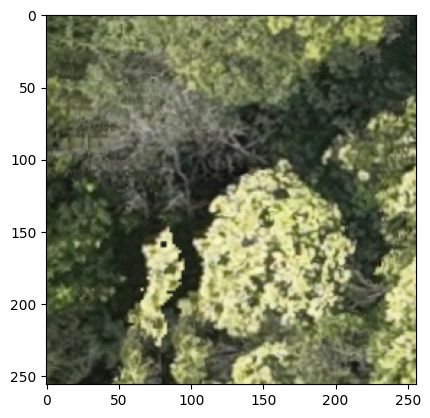

In [27]:
import random
import matplotlib.pyplot as plt

img_num = random.randint(0, filtered_patches.shape[0]-1)

single_patch = Image.fromarray(filtered_patches[img_num])
plt.imshow(single_patch)

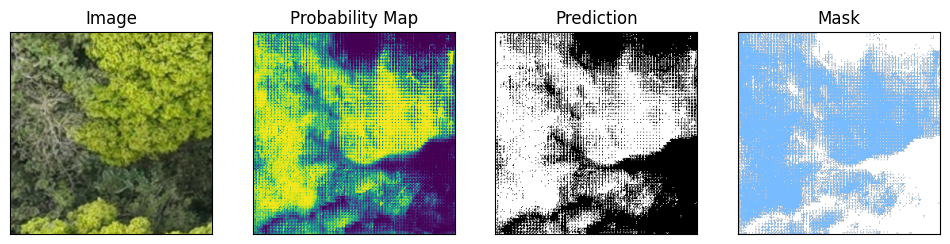

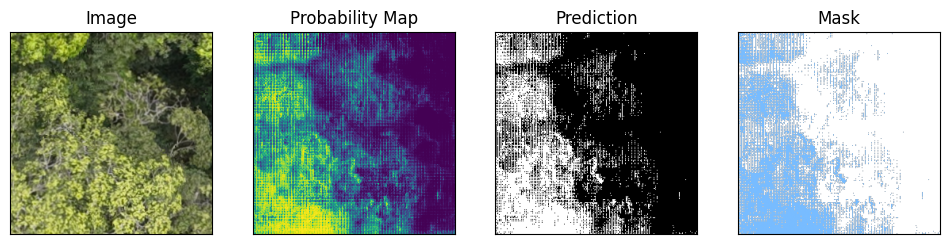

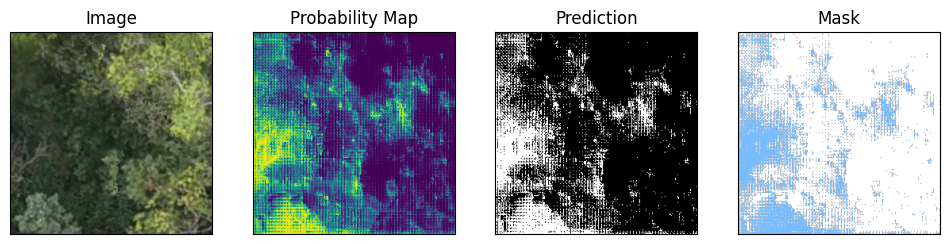

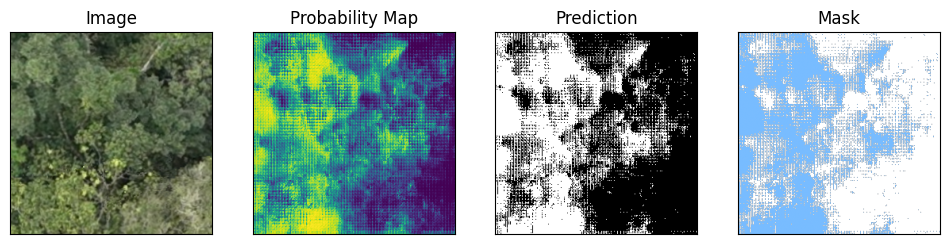

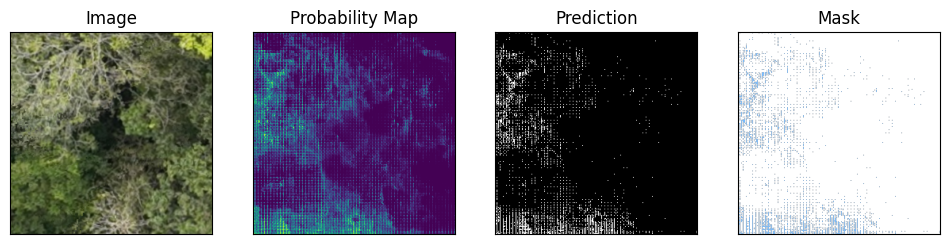

In [30]:
from PIL import Image
import matplotlib.pyplot as plt

patches = filtered_patches
# print(patches.shape)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def test(i):
  random_array = patches[i]

  single_patch = Image.fromarray(random_array)

  #First try without providing any prompt (no bounding box or input_points)
  # inputs = processor(single_patch, return_tensors="pt")
  #Now try with bounding boxes. Remember to uncomment.
  inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

  # Move the input tensor to the GPU if it's not already there
  inputs = {k: v.to(device) for k, v in inputs.items()}
  my_model.eval()


  # forward pass
  with torch.no_grad():
    outputs = my_model(**inputs, multimask_output=False)

  # apply sigmoid
  single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
  # convert soft mask to hard mask
  single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
  # print(single_patch_prob)
  single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)
  # print(single_patch_prediction)

  fig, axes = plt.subplots(1, 4, figsize=(12, 3))

  # Plot the first image on the left
  axes[0].imshow(np.array(single_patch))  # Assuming the first image is grayscale
  axes[0].set_title("Image")

  # Plot the second image on the right
  axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
  axes[1].set_title("Probability Map")

  # Plot the second image on the right
  axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
  axes[2].set_title("Prediction")

  show_mask(single_patch_prediction, axes[3])
  axes[3].set_title("Mask")

  # Hide axis ticks and labels
  for ax in axes:
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_xticklabels([])
      ax.set_yticklabels([])

  # Display the images side by side
  plt.show()

for i in range(5):
  patches_num = random.randint(0, filtered_patches.shape[0]-1)
  test(patches_num)